In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

In [3]:
## useful image functions ... I'll talk about these in class

#dilation
def dilate(image, x, y, iterations):
    kernel = np.ones((x,y),np.uint8)
    return cv2.dilate(image, kernel, iterations = iterations)
    
#erosion
def erode(image, x, y, iterations):
    kernel = np.ones((x,y),np.uint8)
    return cv2.erode(image, kernel, iterations = iterations)

# white black ratio
def white_black_ratio(threshed_image):
    total = sum([len(i) for i in threshed])
    white = 0
    for i in threshed_image:
        for j in i:
            if j == 0:
                white +=1
    return white/total

In [82]:
# retrieve lists of all matching image files from subdirectories
text_page = glob.glob('page_images/text_page/*.png')
image_page = glob.glob('page_images/image_page/*.png')
mixed_page = glob.glob('page_images/mixed_page/*.png')

print(len(text_page), len(image_page), len(mixed_page))

1292 225 51


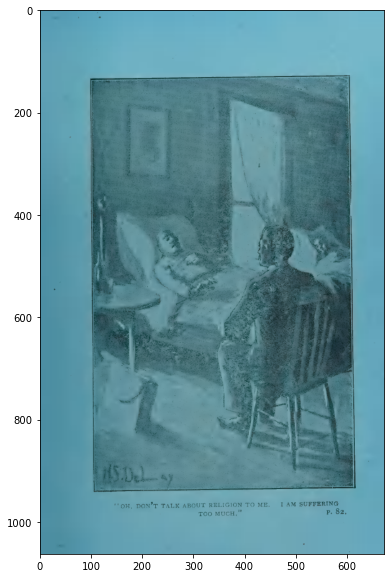

In [67]:
# load one image as a numpy array
one_image_page = cv2.imread(image_page[178])
# convert to rgb
rgb = cv2.cvtColor(one_image_page, cv2.COLOR_BGR2RGB)
# set size of image
plt.figure(figsize=(15,10)) 
# display image inline
plt.imshow(one_image_page)

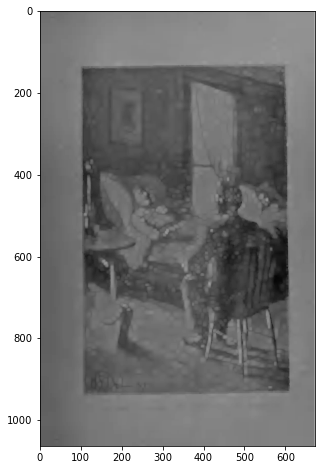

In [68]:
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray, 5)
eroded = erode(gray,3,3,2)
dilated = dilate(gray,3,3,2)
th, threshed = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)

plt.figure(figsize = (12,8))
plt.imshow(dilated, cmap='gray')
plt.show()


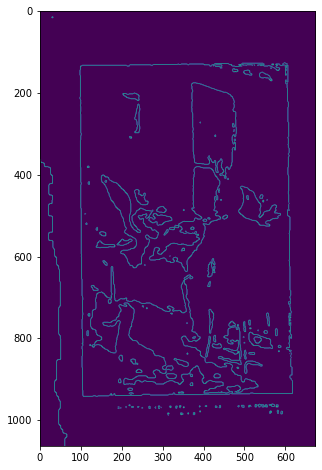

In [69]:
edges = cv2.Canny(threshed, 100, 200)

contours_img = rgb.copy()
contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#for n in contours:
#    cv2.drawContours(contours_img, [n], -1, (0, 0, 255), 5)
    
plt.figure(figsize = (12,8))
im1 = plt.imshow(contours_img, alpha=0.7)
im2 = plt.imshow(edges, alpha=1)
                 
plt.show()

In [77]:
boxes = rgb.copy()
hulls = rgb.copy()

sizes_img = []
for c in contours:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    sizes_img.append(w*h)
    cv2.rectangle(boxes,(x,y),(x+w,y+h),(0,255,0),3)

for n in contours:
    hull = cv2.convexHull(n)
    cv2.drawContours(hulls, [hull], -1, (255, 0, 0), 3)

np.mean(sizes_img)

7390.71676300578

In [71]:
def polyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

hulls_all = []
for n in contours:
    hull = cv2.convexHull(n)
    hulls_all.append(polyArea2D([i[0] for i in hull]))
    
np.var(hulls_all)

3762335964.5394773

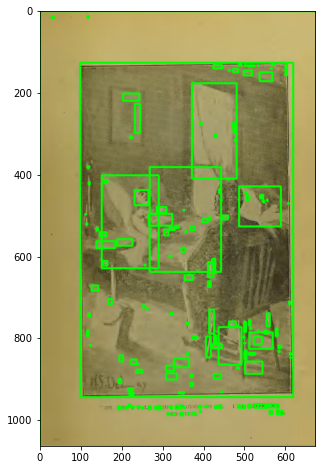

In [78]:
plt.figure(figsize = (12,8))
plt.imshow(boxes)
plt.show()

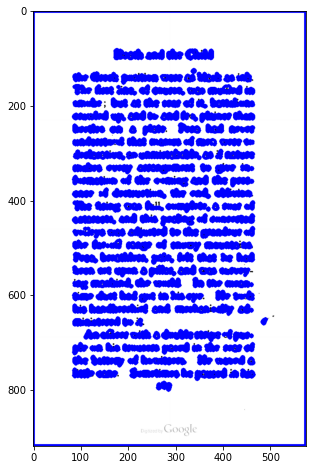

In [83]:
# load one image as a numpy array
text_page_img = cv2.imread(text_page[5])
# convert to rgb
rgb_text = cv2.cvtColor(text_page_img, cv2.COLOR_BGR2RGB)

gray_text = cv2.cvtColor(rgb_text, cv2.COLOR_BGR2GRAY)
blurred_text = cv2.medianBlur(gray_text, 5)
th_text, threshed_text = cv2.threshold(blurred_text, 128, 255, cv2.THRESH_BINARY)

edges_text = cv2.Canny(threshed_text, 100, 200)

contours_img_text = rgb_text.copy()
contours_text, hierarchy_text = cv2.findContours(threshed_text, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for z in contours_text:
    cv2.drawContours(contours_img_text, [z], -1, (0, 0, 255), 5)
plt.figure(figsize = (12,8))
plt.imshow(contours_img_text)

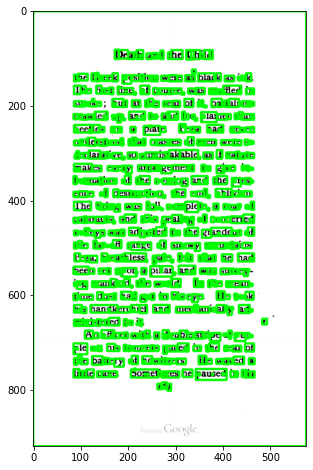

In [84]:
boxes_text = rgb_text.copy()
hulls_text = rgb_text.copy()

sizes = []
for c in contours_text:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    sizes.append(w*h)
    cv2.rectangle(boxes_text,(x,y),(x+w,y+h),(0,255,0),3)

for n in contours_text:
    hull = cv2.convexHull(n)
    cv2.drawContours(hulls_text, [hull], -1, (255, 0, 0), 3)

plt.figure(figsize = (12,8))
plt.imshow(boxes_text)

In [85]:
np.mean(sizes)

764.8012121212121

In [ ]:
pages_binary = text_page + image_page
labels_binary = [0 for i in text_page ] + [1 for i in image_page]
labels_binary[0:10]

In [10]:
ratios = []
threshed_all = []
imgs_all = []
# running this code on 1500+ plus will take a while, but there isn't really a faster way (for me it was ~15 mins)
for i in pages_binary:
    try:
        img = cv2.imread(i)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs_all.append(rgb)
    except:
        imgs_all.append(np.nan)
    try:
        gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
        blurred = cv2.medianBlur(gray, 5)
        eroded = erode(gray,3,3,2)
        dilated = dilate(gray,3,3,2)
        th, threshed = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
        threshed_all.append(threshed)
    except:
        threshed_all.append(np.nan)
    try: 
        wb_score = white_black_ratio(threshed)
        ratios.append(wb_score)
    except:
        ratios.append(np.nan)

In [11]:
len(ratios)

1517

In [13]:
type(imgs_all[0])

numpy.ndarray

In [30]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(ratios), labels_binary , test_size=0.3, random_state=309)
type(X_train)

numpy.ndarray

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', random_state=11).fit(X_train.reshape(-1,1), y_train)
predictions = lr.predict(X_test.reshape(-1, 1))
predict_probs = lr.predict_proba(X_test.reshape(-1, 1))

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[389,   0],
       [ 26,  41]])

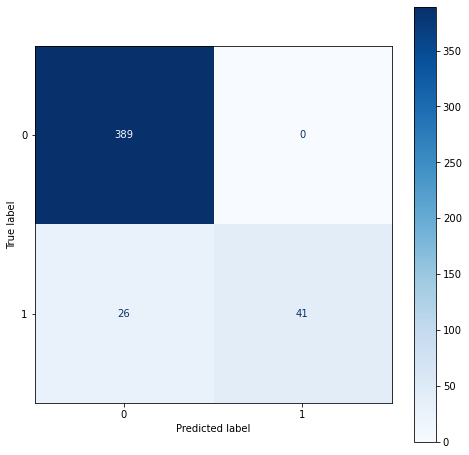

In [53]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(8, 8)) 
plot_confusion_matrix(lr, X_test.reshape(-1,1), y_test, cmap='Blues', ax=ax)  
plt.show()

In [35]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions, average=None)

array([0.9373494, 1.       ])

In [37]:
# recall 
from sklearn.metrics import recall_score
recall_score(y_test, predictions, average=None)

array([1.       , 0.6119403])

In [38]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions, average=None)


array([0.96766169, 0.75925926])

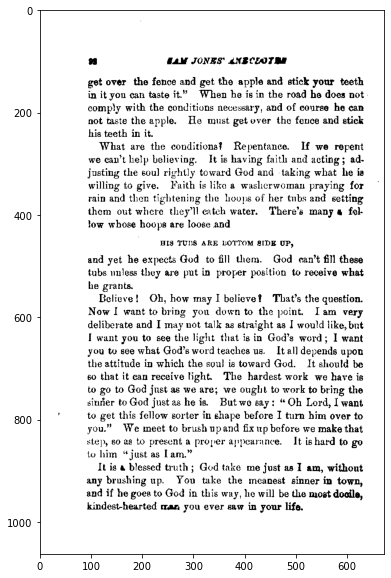

In [34]:
plt.figure(figsize=(15,10)) 
plt.imshow(threshed_all[23], cmap='gray')

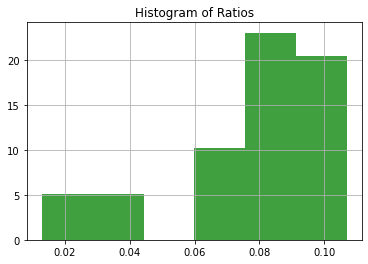

In [35]:
# the histogram of the data
n, bins, patches = plt.hist(ratios, 6, density=True, facecolor='g', alpha=0.75)

plt.title('Histogram of Ratios')
plt.grid(True)
plt.show()

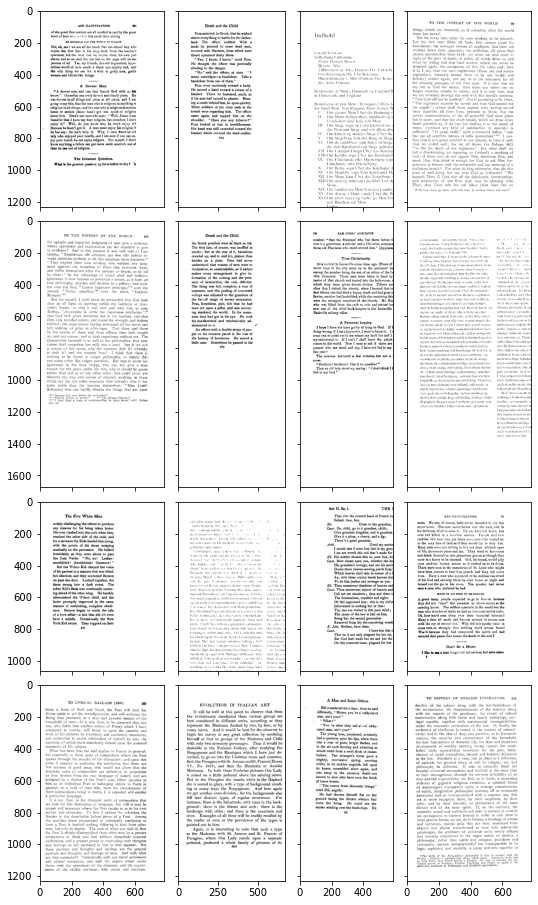

In [36]:
# Display a group of images as a grid
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im in zip(grid, threshed_all):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
# note that some of the images display oddly because they are all different resolutions and dimensions
plt.show()